<h1><center> <font color='black'> Network Analysis of Scientific Collaboration</font></center></h1>
<h2><center> <font color='black'> Link prediction</font></center>

# Libraries

In [1]:
# Importing required libraries

import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
import itertools
import os
import random
from tqdm import tqdm
import re
from itertools import cycle, chain
import lightgbm as lgbm

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

# Data

In [2]:
# Loading the data
df_cc = pd.read_csv('df_cc.csv')
print('Dataset dimension:', df_cc.shape)
df_cc.head()

Dataset dimension: (4923, 3)


,source,target,weight
0,1605636,64684,1
1,1605636,1343349,1
2,1605636,1352169,1
3,1605636,451036,1
4,1605636,569658,1


Using the code from the practice session 6 to prepare the data

In [3]:
# create graph
G_t = nx.from_pandas_edgelist(df_cc, "source", "target", create_using=nx.Graph())

# combine all nodes in a list
node_list = list(df_cc['source']) + list(df_cc['target'])

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G_t, nodelist = node_list)

# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
        if nx.shortest_path_length(G_t, node_list[i], node_list[j]) <= 2:
            if adj_G[i,j] == 0:
                all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1


node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'source':node_1_unlinked, 
                     'target':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

initial_node_count = len(G_t.nodes)

df_cc_temp = df_cc.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(df_cc.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(df_cc_temp.drop(index = i), "source", "target", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    df_cc_temp = df_cc_temp.drop(index = i)
    

# create dataframe of removable edges
df_cc_ghost = df_cc.loc[omissible_links_index]

# add the target variable 'link'
df_cc_ghost['link'] = 1

data = data.append(df_cc_ghost[['source', 'target', 'link']], ignore_index=True)

# drop removable edges
df_cc_partial = df_cc.drop(index=df_cc_ghost.index.values)

# build graph
G_final = nx.from_pandas_edgelist(df_cc_partial, "source", "target", create_using=nx.Graph())

100%|██████████| 4923/4923 [01:20<00:00, 61.16it/s]


In [4]:
# To check if the data is imbalanced
data['link'].value_counts()

0    37474
1     3217
Name: link, dtype: int64

# Scoring methods

In [5]:
# 1. Number of common neighbors
data['common_neighbor'] = 0
for i in range(data.shape[0]):
  data.loc[i,'common_neighbor'] = len(list(nx.common_neighbors(G_final, data.loc[i,'source'], data.loc[i, 'target'])))

In [6]:
# 2. Jaccard coefficient
data['jaccard_similarity'] = 0
for i in range(data.shape[0]):
    data.loc[i, 'jaccard_similarity'] = list(nx.jaccard_coefficient(G_final, [(data.loc[i, 'source'], data.loc[i, 'target'])]))[0][2]

In [7]:
# 3. Adamic/Adar
data['adamic_adar_index'] = 0
for i in range(data.shape[0]):
  data.loc[i, 'adamic_adar_index'] = list(nx.adamic_adar_index(G_final, [(data.loc[i, 'source'], data.loc[i, 'target'])]))[0][2]

In [8]:
# 4. Shortest path
data['shortest_path'] = 0
for i in range(data.shape[0]):
    data.loc[i, 'shortest_path'] = nx.shortest_path_length(G_final, source = data.loc[i, 'source'], target = data.loc[i, 'target'])

In [9]:
# 5. Preferrential attachment
data['preferrential_attachment'] = 0
for i in range(data.shape[0]):
    data.loc[i, 'preferrential_attachment'] = list(nx.preferential_attachment(G_final, [(data.loc[i, 'source'], data.loc[i, 'target'])]))[0][2]

In [10]:
# 6. Hitting times 
# done as in the PS 6
from statistics import mode 
data['hitting_time'] = 0
for i in range(data.shape[0]):
  all_simple_paths = nx.all_simple_paths(G_final, data.loc[i, 'source'], data.loc[i, 'target'])
  dist = []
  for path in all_simple_paths:
    dist.append(len(path))
  data.loc[i, 'hitting_time'] = mode(dist)

In [11]:
data.head()

,source,target,link,common_neighbor,jaccard_similarity,adamic_adar_index,shortest_path,preferrential_attachment,hitting_time
0,1605636,655411,0,0,0.0,0.0,17,1,18
1,1605636,475422,0,0,0.0,0.0,8,1,9
2,1605636,1622358,0,0,0.0,0.0,16,1,17
3,1605636,1229638,0,0,0.0,0.0,7,1,8
4,1605636,476673,0,0,0.0,0.0,10,1,11


In [12]:
x = data.drop(columns=['source', 'target', 'link'])
y = data['link']

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size = 0.3, 
                                                random_state = 35)

In [14]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)
predictions = lr.predict_proba(xtest)
lr_predictions = lr.predict(xtest)

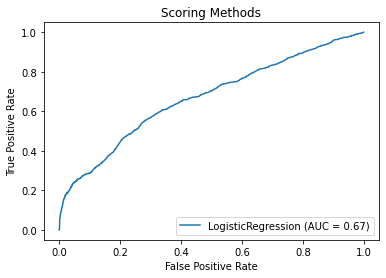

In [15]:
metrics.plot_roc_curve(lr, xtest, ytest) 
plt.title('Scoring Methods')
plt.show()  

In [16]:
print('roc_auc_score', roc_auc_score(ytest, predictions[:,1]))
print('accuracy_score', metrics.accuracy_score(ytest, lr_predictions))
print('f1_score', metrics.f1_score(ytest, lr_predictions))
print('recall_score', metrics.recall_score(ytest, lr_predictions))
print('precision_score', metrics.precision_score(ytest, lr_predictions))
print('mean_squared_error', metrics.mean_squared_error(ytest, lr_predictions))

roc_auc_score 0.6686294154435805
accuracy_score 0.7276376146788991
f1_score 0.23014586709886548
recall_score 0.5092213114754098
precision_score 0.14866886030511517
mean_squared_error 0.2723623853211009


In [17]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2)
rf.fit(xtrain, ytrain)

predictions = rf.predict_proba(xtest)
rf_predictions = rf.predict(xtest)

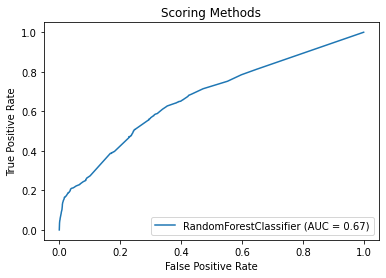

In [18]:
metrics.plot_roc_curve(rf, xtest, ytest) 
plt.title('Scoring Methods')
plt.show()  

In [19]:
print('roc_auc_score', roc_auc_score(ytest, predictions[:,1]))
print('accuracy_score', metrics.accuracy_score(ytest, rf_predictions))
print('f1_score', metrics.f1_score(ytest, rf_predictions))
print('recall_score', metrics.recall_score(ytest, rf_predictions))
print('precision_score', metrics.precision_score(ytest, rf_predictions))
print('mean_squared_error', metrics.mean_squared_error(ytest, rf_predictions))

roc_auc_score 0.6695009373832376
accuracy_score 0.9200524246395806
f1_score 0.0
recall_score 0.0
precision_score 0.0
mean_squared_error 0.0799475753604194


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


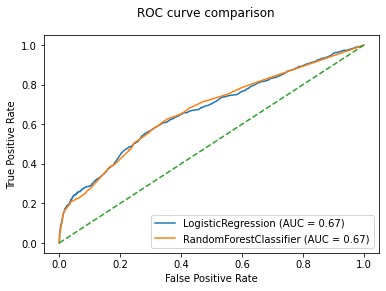

In [20]:
lr_disp = metrics.plot_roc_curve(lr, xtest, ytest)
rf_disp = metrics.plot_roc_curve(rf, xtest, ytest, ax=lr_disp.ax_)
rf_disp.figure_.suptitle("ROC curve comparison")
plt.plot([0, 1], [0, 1],linestyle='--')
plt.show()

# Node2Vec

In [21]:
!pip install node2vec
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_final, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


In [22]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['source'], data['target'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [23]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [24]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)
predictions = lr.predict_proba(xtest)
lr_predictions = lr.predict(xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


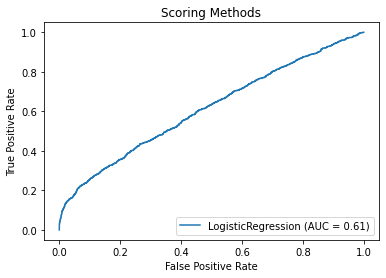

In [25]:
metrics.plot_roc_curve(lr, xtest, ytest) 
plt.title('Scoring Methods')
plt.show()  

In [26]:
print('roc_auc_score', roc_auc_score(ytest, predictions[:,1]))
print('accuracy_score', metrics.accuracy_score(ytest, lr_predictions))
print('f1_score', metrics.f1_score(ytest, lr_predictions))
print('recall_score', metrics.recall_score(ytest, lr_predictions))
print('precision_score', metrics.precision_score(ytest, lr_predictions))
print('mean_squared_error', metrics.mean_squared_error(ytest, lr_predictions))

roc_auc_score 0.6124647341027977
accuracy_score 0.6354849279161205
f1_score 0.17987467747880576
recall_score 0.5
precision_score 0.10966292134831461
mean_squared_error 0.3645150720838794


In [27]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2)
rf.fit(xtrain, ytrain)

predictions = rf.predict_proba(xtest)
rf_predictions = rf.predict(xtest)

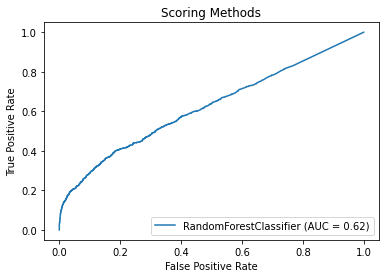

In [28]:
metrics.plot_roc_curve(rf, xtest, ytest) 
plt.title('Scoring Methods')
plt.show()  

In [29]:
print('roc_auc_score', roc_auc_score(ytest, predictions[:,1]))
print('accuracy_score', metrics.accuracy_score(ytest, rf_predictions))
print('f1_score', metrics.f1_score(ytest, rf_predictions))
print('recall_score', metrics.recall_score(ytest, rf_predictions))
print('precision_score', metrics.precision_score(ytest, rf_predictions))
print('mean_squared_error', metrics.mean_squared_error(ytest, rf_predictions))

roc_auc_score 0.6223234497600533
accuracy_score 0.9200524246395806
f1_score 0.0
recall_score 0.0
precision_score 0.0
mean_squared_error 0.0799475753604194


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
